# Titanic survival - feature selection 1 (univariate statistical selection)

In [12]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

In [13]:
#Load modules
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [14]:
#Load data
data = pd.read_csv('C:/t_data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [15]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

In [16]:
#Divide into X (features) and y (labels)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Calculate correlation coefficients

In [17]:
from scipy.stats.stats import pearsonr
features = list(X)
correlation = []
significance = []
for feature in features:
    correl = pearsonr(X[feature].values, y.values)
    correlation.append(correl[0])
    significance.append(correl[1])
df = pd.DataFrame()
df['feature'] = features
df['correlation'] = correlation
df['abs_correlation'] = np.abs(correlation)
df['significance'] = significance
df['significant'] = df['significance'] < 0.05 # Label those P<0.01
df.sort_values(by='abs_correlation', ascending=False, inplace=True)

In [18]:
df

,feature,correlation,abs_correlation,significance,significant
10,male,-0.543351,0.543351,1.406066e-69,True
0,Pclass,-0.338481,0.338481,2.537047e-25,True
9,CabinNumberImputed,-0.321842,0.321842,6.404266e-23,True
7,CabinLetterImputed,-0.316912,0.316912,3.090891e-22,True
23,CabinLetter_missing,-0.316912,0.316912,3.090891e-22,True
4,Fare,0.257307,0.257307,6.120189e-15,True
8,CabinNumber,0.235409,0.235409,1.100977e-12,True
16,CabinLetter_B,0.175095,0.175095,1.441584e-07,True
11,Embarked_C,0.168240,0.168240,4.397151e-07,True
13,Embarked_S,-0.155660,0.155660,3.036111e-06,True


In [19]:
ordered_features = list(df['feature'])

In [20]:
ordered_features

['male',
 'Pclass',
 'CabinNumberImputed',
 'CabinLetterImputed',
 'CabinLetter_missing',
 'Fare',
 'CabinNumber',
 'CabinLetter_B',
 'Embarked_C',
 'Embarked_S',
 'CabinLetter_D',
 'CabinLetter_E',
 'CabinLetter_C',
 'AgeImputed',
 'Parch',
 'Age',
 'Embarked_missing',
 'EmbarkedImputed',
 'CabinLetter_F',
 'SibSp',
 'CabinLetter_T',
 'CabinLetter_A',
 'CabinLetter_G',
 'Embarked_Q']

## Testing our selected features

In [21]:

def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [22]:
# Create list to store accuracies
accuracy_by_feature_number = []
roc_auc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)
for i in range(number_of_features):
    # print ("{0} features of {1}".format(i, number_of_features))
    features_to_use = ordered_features[0:i+1]
    X_selected = X[features_to_use]
    
    # Convert to NumPy (needed for k-fold method)
    # Convert DataFrames to NumPy arrays
    X_np = X_selected.values
    y_np = y.values
    
    #%% Run k fold model

    # Set up lists to hold results for each k-fold run
    test_acc_results = []
    test_auc_results = []

    # Set up splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y)

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std,y_train)

        # Predict test set labels
        y_pred_test = model.predict(X_test_std)
        
        # Calculate accuracy of test sets
        accuracy_test = np.mean(y_pred_test == y_test)
        test_acc_results.append(accuracy_test)
        
        # Get ROC AUC
        probabilities = model.predict_proba(X_test_std)
        probabilities = probabilities[:, 1] # Probability of 'survived' class
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        test_auc_results.append(roc_auc)      
        
    # Add mean accuracy and AUC to record of accuracy by feature number
    accuracy_by_feature_number.append(np.mean(test_acc_results))
    roc_auc_by_feature_number.append(np.mean(test_auc_results)) 

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

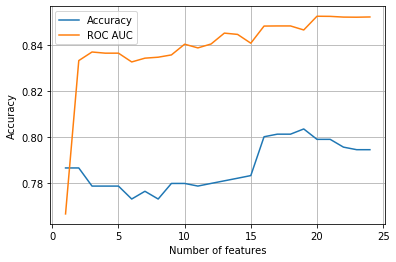

In [24]:
chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, accuracy_by_feature_number,
        label = 'Accuracy')

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()